# Data Integration

**Goal:**  
Merge restaurant inspection data with crime and property data to create features for predicting inspection scores.

**Plan:**
1. Load all three cleaned datasets (DOHMH, NYPD, PLUTO)
2. For each restaurant, count crimes within ~500m radius
3. For each restaurant, find nearest property and get its characteristics
4. Create master dataset with all features combined
5. Save for modeling


In [8]:
#Loading data
# Using cKDTree for fast spatial searches. The datasets we are using are large and checking for every crime against every restaurant would be too slow.
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree

print("Libraries loaded!")


Libraries loaded!


## Load Cleaned Datasets


In [9]:
# Loading data
print("Loading DOHMH restaurant data...")
restaurants = pd.read_csv('../data/processed/dohmh_restaurants_clean.csv')
print(f"Restaurants: {len(restaurants):,} rows")


print("Loading NYPD crime data...")
crimes = pd.read_csv('../data/processed/nypd_complaints_clean.csv')
print(f"Crimes: {len(crimes):,} rows")

 
print("Loading PLUTO property data...")
properties = pd.read_csv('../data/processed/pluto_nyc_clean.csv')
print(f"Properties: {len(properties):,} rows")


Loading DOHMH restaurant data...
Restaurants: 26,572 rows
Loading NYPD crime data...


/var/folders/_l/_85pbswx3gb9p0649jw7x4rm0000gn/T/ipykernel_13218/2010497889.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  crimes = pd.read_csv('../data/processed/nypd_complaints_clean.csv')


Crimes: 9,491,467 rows
Loading PLUTO property data...
Properties: 857,025 rows


In [10]:
# Quick look at each dataset
print("Restaurant columns:", restaurants.columns.tolist())
print("\nCrime columns:", crimes.columns.tolist())
print("\nProperty columns:", properties.columns.tolist())


Restaurant columns: ['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'CUISINE_DESCRIPTION', 'Latitude', 'Longitude', 'first_inspection', 'last_inspection', 'num_inspections', 'avg_score', 'worst_score', 'best_score', 'last_score', 'last_grade']

Crime columns: ['CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'ADDR_PCT_CD', 'OFNS_DESC', 'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'BORO_NM', 'Latitude', 'Longitude']

Property columns: ['borough', 'address', 'landuse', 'bldgclass', 'yearbuilt', 'assesstot', 'latitude', 'longitude']


## Count Crimes Near Each Restaurant

For each restaurant, we count how many crimes occurred within ~500m.

In [11]:
# Prepare crime coordinates
# Drop any rows with missing coordinates
crimes_clean = crimes.dropna(subset=['Latitude', 'Longitude']).copy()
print(f"Crimes with valid coordinates: {len(crimes_clean):,}")

# Build KD-Tree for crimes (for fast spatial queries)
crime_coords = crimes_clean[['Latitude', 'Longitude']].values
crime_tree = cKDTree(crime_coords)
print("Crime KD-Tree built!")


Crimes with valid coordinates: 9,491,467
Crime KD-Tree built!


In [12]:
# Count crimes within radius for each restaurant
# 0.005 degrees is approximately 500 meters
RADIUS = 0.005

print("Counting crimes near each restaurant (this may take a minute)...")

restaurant_coords = restaurants[['Latitude', 'Longitude']].values
crime_counts = []

for i, (lat, lon) in enumerate(restaurant_coords):
    indices = crime_tree.query_ball_point([lat, lon], RADIUS)
    crime_counts.append(len(indices))
    
    if (i + 1) % 5000 == 0:
        print(f"  Processed {i + 1:,} / {len(restaurants):,} restaurants...")

restaurants['crimes_nearby'] = crime_counts
print(f"Done! Average crimes per restaurant: {np.mean(crime_counts):.1f}")

Counting crimes near each restaurant (this may take a minute)...
  Processed 5,000 / 26,572 restaurants...
  Processed 10,000 / 26,572 restaurants...
  Processed 15,000 / 26,572 restaurants...
  Processed 20,000 / 26,572 restaurants...
  Processed 25,000 / 26,572 restaurants...
Done! Average crimes per restaurant: 26296.5


In [ ]:
## Match Restaurants to Nearest Property
#Find the nearest PLUTO property for each restaurant and get its characteristics.

In [13]:
# Prepare property coordinates
properties_clean = properties.dropna(subset=['latitude', 'longitude']).copy()
print(f"Properties with valid coordinates: {len(properties_clean):,}")

# Build KD-Tree for properties
property_coords = properties_clean[['latitude', 'longitude']].values
property_tree = cKDTree(property_coords)
print("Property KD-Tree built!")

# Find nearest property for each restaurant
print("Finding nearest property for each restaurant...")
distances, indices = property_tree.query(restaurant_coords, k=1)

# Get property features
restaurants['property_yearbuilt'] = properties_clean.iloc[indices]['yearbuilt'].values
restaurants['property_assesstot'] = properties_clean.iloc[indices]['assesstot'].values
restaurants['property_landuse'] = properties_clean.iloc[indices]['landuse'].values

print("Done!")

Properties with valid coordinates: 857,025
Property KD-Tree built!
Finding nearest property for each restaurant...
Done!


In [ ]:
## Review and Save Master Dataset

In [14]:
# View the integrated dataset
print(f"Master dataset shape: {restaurants.shape}")
print(f"\nNew columns added:")
print("- crimes_nearby")
print("- property_yearbuilt")
print("- property_assesstot")
print("- property_landuse")
restaurants.head()

Master dataset shape: (26572, 21)

New columns added:
- crimes_nearby
- property_yearbuilt
- property_assesstot
- property_landuse


,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,CUISINE_DESCRIPTION,Latitude,Longitude,first_inspection,...,num_inspections,avg_score,worst_score,best_score,last_score,last_grade,crimes_nearby,property_yearbuilt,property_assesstot,property_landuse
0,30075445,MORRIS PARK BAKE SHOP,Bronx,1007,MORRIS PARK AVENUE,10462.0,Bakery Products/Desserts,40.848231,-73.855972,2023-01-31,...,19,19.684211,38.0,10.0,13.0,P,7675,1937.0,800100.0,4.0
1,30191841,D.J. REYNOLDS,Manhattan,351,WEST 57 STREET,10019.0,Irish,40.767326,-73.984310,2023-04-23,...,10,18.400000,24.0,10.0,24.0,A,46029,1960.0,2230650.0,4.0
2,40356018,RIVIERA CATERERS,Brooklyn,2780,STILLWELL AVENUE,11224.0,American,40.579896,-73.982087,2024-04-16,...,3,6.666667,10.0,0.0,0.0,A,13313,1924.0,385200.0,2.0
3,40356483,WILKEN'S FINE FOOD,Brooklyn,7114,AVENUE U,11234.0,Sandwiches,40.620112,-73.906989,2022-01-24,...,20,23.650000,35.0,2.0,21.0,A,2667,1960.0,81360.0,1.0
4,40356731,TASTE THE TROPICS ICE CREAM,Brooklyn,1839,NOSTRAND AVENUE,11226.0,Frozen Desserts,40.640795,-73.948488,2023-01-17,...,9,11.333333,12.0,9.0,12.0,A,23195,1933.0,49680.0,4.0


Need to fix last few missing values before saving master dataset

In [ ]:

print("Missing BEFORE:")
print(restaurants[["ZIPCODE", "property_yearbuilt", "property_assesstot", "property_landuse"]].isna().sum())

restaurants["property_yearbuilt"] = restaurants["property_yearbuilt"].fillna(restaurants["property_yearbuilt"].median())
restaurants["property_assesstot"] = restaurants["property_assesstot"].fillna(restaurants["property_assesstot"].median())
restaurants["property_landuse"] = restaurants["property_landuse"].fillna("Unknown")
restaurants["ZIPCODE"] = restaurants["ZIPCODE"].fillna(restaurants["ZIPCODE"].mode()[0])

print("\nMissing AFTER:")
print(restaurants[["ZIPCODE", "property_yearbuilt", "property_assesstot", "property_landuse"]].isna().sum())


Missing BEFORE:
ZIPCODE               0
property_yearbuilt    0
property_assesstot    0
property_landuse      0
dtype: int64

Missing AFTER:
ZIPCODE               0
property_yearbuilt    0
property_assesstot    0
property_landuse      0
dtype: int64


In [28]:
# Save master dataset
output_path = '../data/processed/master_restaurant_dataset.csv'
restaurants.to_csv(output_path, index=False)

print(f"Saved master dataset to: {output_path}")
print(f"Total rows: {len(restaurants):,}")
print(f"Total columns: {len(restaurants.columns)}")
print("\nData integration complete!")


Saved master dataset to: ../data/processed/master_restaurant_dataset.csv
Total rows: 26,572
Total columns: 21

Data integration complete!


In [ ]:
# Quick summary stats
print("Crime feature stats:")
print(f"  Min crimes nearby: {restaurants['crimes_nearby'].min()}")
print(f"  Max crimes nearby: {restaurants['crimes_nearby'].max()}")
print(f"  Mean crimes nearby: {restaurants['crimes_nearby'].mean():.1f}")


Crime feature stats:
  Min crimes nearby: 0
  Max crimes nearby: 143222
  Mean crimes nearby: 26569.2


### Quick overview of the integrated restaurant dataset

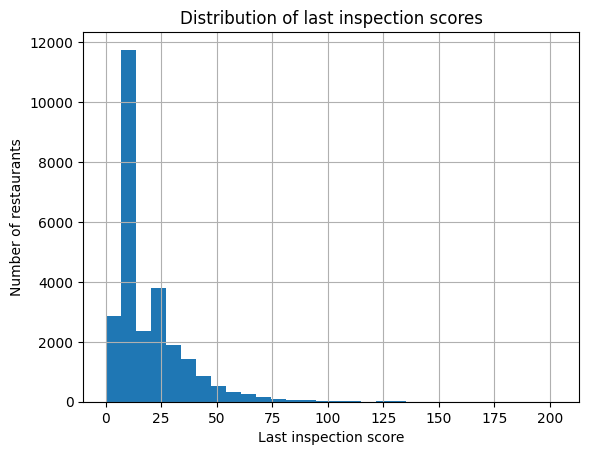

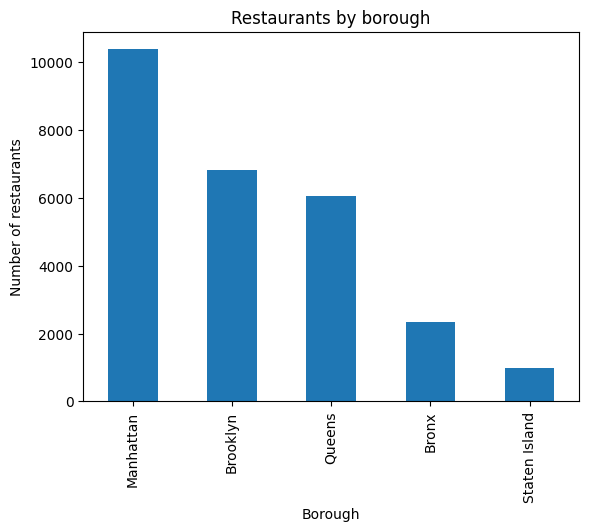

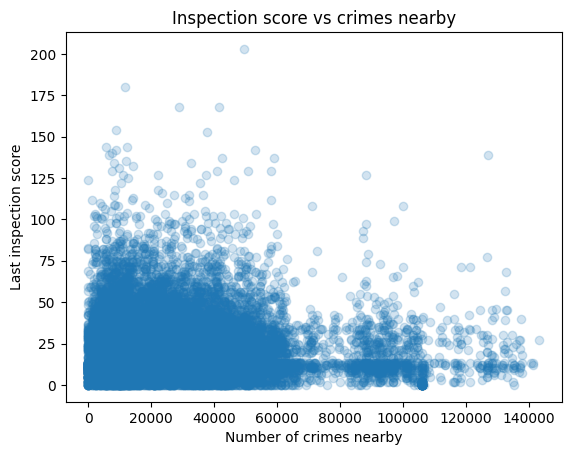

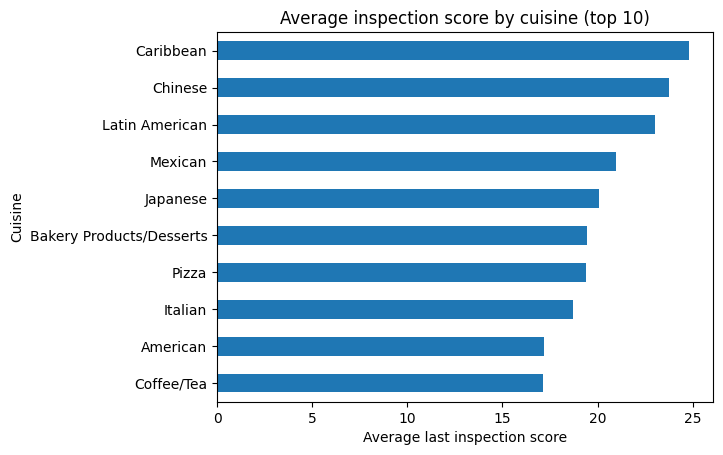

In [30]:
import matplotlib.pyplot as plt

restaurants["last_score"].hist(bins=30)
plt.xlabel("Last inspection score")
plt.ylabel("Number of restaurants")
plt.title("Distribution of last inspection scores")
plt.show()

restaurants["BORO"].value_counts().plot(kind="bar")
plt.xlabel("Borough")
plt.ylabel("Number of restaurants")
plt.title("Restaurants by borough")
plt.show()

plt.scatter(restaurants["crimes_nearby"], restaurants["last_score"], alpha=0.2)
plt.xlabel("Number of crimes nearby")
plt.ylabel("Last inspection score")
plt.title("Inspection score vs crimes nearby")
plt.show()

top_cuisines = (
    restaurants["CUISINE_DESCRIPTION"]
    .value_counts()
    .head(10)
    .index
)

avg_score_by_cuisine = (
    restaurants[restaurants["CUISINE_DESCRIPTION"].isin(top_cuisines)]
    .groupby("CUISINE_DESCRIPTION")["last_score"]
    .mean()
    .sort_values()
)

avg_score_by_cuisine.plot(kind="barh")
plt.xlabel("Average last inspection score")
plt.ylabel("Cuisine")
plt.title("Average inspection score by cuisine (top 10)")
plt.show()
